https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1


https://towardsdatascience.com/similarity-metrics-in-nlp-acc0777e234c 

https://www.youtube.com/watch?v=Ey81KfQ3PQU


Model semantic search: 'multi-qa-MiniLM-L6-cos-v1'

Model assymetric : 'msmarco-MiniLM-L-6-v3'

In [1]:
import sys
import os

# Add the 'Functions' directory to the Python path
sys.path.append(os.path.abspath('../../Functions'))


from connection.connection import *
from AlertP1.data_cleaning import *
from AlertP1.features import *
from analysis.step_analysis import *
from AlertP1.dummy_features import *
from Models.Logistic_regression import *
from Models.evaluation import *
from NLP.data_with_nlp import *
from BERT.bert import *
from pipeline import *

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
# Import argsort
from numpy import argsort
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt

/home/gabrielabib/.conda/envs/nova/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
protocols = pd.read_csv('./BERT/protocols.csv')
protocols_acceptance = protocols[['Acceptance']]
protocols_refusal = protocols[['Refusal']]
protocols_acceptance.dropna(inplace=True)

In [3]:
# # 1. Data cleaning
lower_text(protocols_acceptance,'Acceptance', 'Acceptance')
lower_text(protocols_refusal,'Refusal', 'Refusal')
remove_stop_words(protocols_acceptance,'Acceptance', 'Acceptance')
remove_stop_words(protocols_refusal,'Refusal', 'Refusal')
spacy_lemmatizer(protocols_acceptance,'Acceptance', 'Acceptance')
spacy_lemmatizer(protocols_refusal,'Refusal', 'Refusal')

protocols_acceptance

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Acceptance
0,cefaleia crónico refratária associar abuso med...
1,distúrbio movimento distúrbio equilíbrio quer ...
2,doença neuromuscular genético dor neuropático ...
3,distúrbio aprendizagem retardor psicomotor
4,síndromes demencial demência primário secundár...
5,esclerose múltiplo outro doença desmielinizant...


In [4]:
acceptance_list = protocols_acceptance['Acceptance'].tolist()
acceptance_list

['cefaleia crónico refratária associar abuso medicamentoso',
 'distúrbio movimento distúrbio equilíbrio quer frequente distonia doença parkinson parkinsonismo esclarecer tremor essencial difícil controle ataxias esclarecer coreia / balismos etc',
 'doença neuromuscular genético dor neuropático refratário parestesia recorrente e/ou progressivo paraplegia paresio esclerose lateral amiotrófico suspeito miopatia miastenia grave outro transtorno neuromuscular amiotrofia espinhal síndromes correlato polineuropatia outro transtorno sistema nervoso periférico snp doenço neurogenético',
 'distúrbio aprendizagem retardor psicomotor',
 'síndromes demencial demência primário secundário dúvida diagnósticar demência rapidamente progressivo',
 'esclerose múltiplo outro doença desmielinizante neuroimunológico']

In [5]:
[acceptance_list[0]]

['cefaleia crónico refratária associar abuso medicamentoso']

In [6]:
alertP1 = connection('credentials.txt')
data = pre_process(alertP1)


Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
98


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
split_text_df = data[['COD_REFERENCIA', 'Texto', 'text_length']]
# split_text_df['text_length'] = split_text_df['Texto'].apply(lambda x: len(x.split()))
split_text_df = split_text_df[split_text_df['text_length'] > 0]
split_text_df['text_split'] = split_text_df['Texto'].apply(lambda x: x.split("."))
split_text_df =  split_text_df.explode('text_split')
lower_text(split_text_df,'text_split', 'text_split')
remove_stop_words(split_text_df,'text_split', 'text_split')
spacy_lemmatizer(split_text_df,'text_split', 'text_split')
split_text_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,COD_REFERENCIA,Texto,text_length,text_split
630,LOHHHSHT,"Doente de 71 anos de idade, com tremor acentua...",301,doente 71 ano idade tremor acentuar membro alt...
630,LOHHHSHT,"Doente de 71 anos de idade, com tremor acentua...",301,
1537,LOHHLSTU,Sem relatorio clinico,21,relatorio clinico
985,LOHHLTRS,Traz inumeros relatorios das idas ao HGO-SU po...,401,trazer inumero relatorio ida hgo-su vulvo-vagi...
985,LOHHLTRS,Traz inumeros relatorios das idas ao HGO-SU po...,401,relatorio sobre ida crise epilepsio ter ser me...
...,...,...,...,...
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,d
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,l
1332,LSHVHSUR,Doente com episódios frequentes de desorientaç...,483,estimativa 161 perturbação sono alteração memória
1227,LSHVHUHL,Dte 79 anos com AVC HE ha 6 meses comm sequela...,149,dte 79 ano avc he ha 6 mês comm sequelo disart...


In [8]:
# alertP1_simplified = alertP1[['COD_REFERENCIA', 'Texto']]

In [9]:
# alertP1_simplified.info()

In [10]:
# lower_text(alertP1_simplified,'Texto', 'Texto')
# remove_stop_words(alertP1_simplified,'Texto', 'Texto_Stop_Words')
# spacy_lemmatizer(alertP1_simplified,'Texto_Stop_Words', 'text_lemmatized')
# alertP1_simplified

In [11]:
# model_name = 'pucpr/biobertpt-all'
model_name = 'sentence-transformers/msmarco-MiniLM-L-6-v3'

In [12]:
from sentence_transformers import SentenceTransformer

In [13]:
model = SentenceTransformer(model_name)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

referrals = split_text_df['text_split'].tolist()


for index, protocol in enumerate(acceptance_list):

    sentences = [protocol] + referrals

    sentences_vectors = model.encode(sentences)

    results = cosine_similarity([sentences_vectors[0]], sentences_vectors[1:])

    column_name = 'acc_prot_' + str(index)

    split_text_df[column_name] = results[0]

    


In [15]:
split_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7924 entries, 630 to 1227
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COD_REFERENCIA  7924 non-null   object 
 1   Texto           7924 non-null   object 
 2   text_length     7924 non-null   int64  
 3   text_split      7924 non-null   object 
 4   acc_prot_0      7924 non-null   float32
 5   acc_prot_1      7924 non-null   float32
 6   acc_prot_2      7924 non-null   float32
 7   acc_prot_3      7924 non-null   float32
 8   acc_prot_4      7924 non-null   float32
 9   acc_prot_5      7924 non-null   float32
dtypes: float32(6), int64(1), object(3)
memory usage: 495.2+ KB


In [16]:
columns_bert = ['acc_prot_0','acc_prot_1','acc_prot_2','acc_prot_3','acc_prot_4','acc_prot_5']
split_text_df2 = split_text_df.groupby('COD_REFERENCIA')[columns_bert].max()
split_text_df2

,acc_prot_0,acc_prot_1,acc_prot_2,acc_prot_3,acc_prot_4,acc_prot_5
COD_REFERENCIA,,,,,,
LOHHHSHT,0.131758,0.442293,0.268917,0.304502,0.323050,0.255526
LOHHLSTU,0.226719,0.132739,0.190538,0.267070,0.105469,0.227052
LOHHLTOL,0.426040,0.307145,0.599181,0.356770,0.443019,0.393874
LOHHLTOU,0.218256,0.320066,0.459118,0.232886,0.243360,0.315337
LOHHLTRS,0.247632,0.211375,0.245495,0.161026,0.136488,0.084279
...,...,...,...,...,...,...
LSHUVULH,0.182496,0.368013,0.350938,0.294268,0.247503,0.348381
LSHVHLHP,0.300475,0.320493,0.414138,0.313335,0.323930,0.385963
LSHVHLLH,0.349065,0.335451,0.464020,0.392375,0.399449,0.426315


In [17]:
data = data.merge(split_text_df2, on='COD_REFERENCIA', how='left')
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,USF A,USF B,outro,not accepted before,acc_prot_0,acc_prot_1,acc_prot_2,acc_prot_3,acc_prot_4,acc_prot_5
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,1,0,0,1,0.131758,0.442293,0.268917,0.304502,0.323050,0.255526
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0,0,0,1,0.226719,0.132739,0.190538,0.267070,0.105469,0.227052
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0,1,0,1,0.247632,0.211375,0.245495,0.161026,0.136488,0.084279
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,1,0,1,0.277710,0.372633,0.356521,0.273606,0.278282,0.374722
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,1,0,1,0.218256,0.320066,0.459118,0.232886,0.243360,0.315337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0,0,0,1,0.182496,0.368013,0.350938,0.294268,0.247503,0.348381
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0,1,0,1,0.349065,0.335451,0.464020,0.392375,0.399449,0.426315
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0,0,0,0,0.300475,0.320493,0.414138,0.313335,0.323930,0.385963
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0,1,0,1,0.352970,0.266572,0.339036,0.416879,0.333333,0.314185


In [18]:
# alertP1_simplified.describe()
import xgboost as xgb


In [19]:
def precision_at_k(y_true, y_pred, k):
    y_true = y_true.to_numpy()
    # Get the indices of the top k predictions
    top_k_indices = np.argsort(y_pred)[-k:]
    # Get the top k predictions
    top_k_predictions = y_true[top_k_indices]
    # Calculate precision@k
    precision = np.sum(top_k_predictions) / k
    return precision

In [20]:
def xgb_classifier(features, target):
    
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)

    # X_train['before_accepted'] = X_train['before_accepted'].astype('category')
    # X_test['before_accepted'] = X_test['before_accepted'].astype('category')

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.3,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    # Make preictions on the train set
    y_pred_train = bst.predict(dtrain)
    # Make predictions on the test set
    y_pred_test = bst.predict(dtest)
    
    return y_pred_train, y_pred_test, bst.get_score(), X_train, X_test, y_train, y_test    

In [21]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [22]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc, confusion_matrix, cohen_kappa_score

def evaluate_thresholds(y_pred_train, y_train, y_pred_test, y_test, metrics = "test", k=211):
    #Precion@k
    def precision_at_k(y_true, y_pred, k):
        y_true = y_true.to_numpy()
        # Get the indices of the top k predictions
        top_k_indices = np.argsort(y_pred)[-k:]
        # Get the top k predictions
        top_k_predictions = y_true[top_k_indices]
        # Calculate precision@k
        precision = np.sum(top_k_predictions) / k
        return precision

    if metrics == "test":
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_test >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_test, default_y_pred_binary)
        default_recall = recall_score(y_test, default_y_pred_binary)
        default_precision = precision_score(y_test, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_test, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_test >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_test, pr_y_pred_binary)
        pr_recall = recall_score(y_test, pr_y_pred_binary)
        pr_precision = precision_score(y_test, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_test, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_test >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_test, ba_y_pred_binary)
        ba_recall = recall_score(y_test, ba_y_pred_binary)
        ba_precision = precision_score(y_test, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_test, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_test, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_test, kappa_y_pred_binary)
        kappa_recall = recall_score(y_test, kappa_y_pred_binary)
        kappa_precision = precision_score(y_test, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_test, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_test >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_test, limit_to_k_y_pred_binary, k)

    else:
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_train >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_train, default_y_pred_binary)
        default_recall = recall_score(y_train, default_y_pred_binary)
        default_precision = precision_score(y_train, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_train, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_train >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_train, pr_y_pred_binary)
        pr_recall = recall_score(y_train, pr_y_pred_binary)
        pr_precision = precision_score(y_train, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_train, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_train >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_train, ba_y_pred_binary)
        ba_recall = recall_score(y_train, ba_y_pred_binary)
        ba_precision = precision_score(y_train, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_train, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_train >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_train, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_train, kappa_y_pred_binary)
        kappa_recall = recall_score(y_train, kappa_y_pred_binary)
        kappa_precision = precision_score(y_train, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_train, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_train >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_train, limit_to_k_y_pred_binary, k)

    # Create output dataframe
    data = {
        'Analysis': ['Default', 'Precision-Recall trade-off', 'Balanced Accuracy', "Cohen's Kappa", 'Limit to K'],
        'Threshold': [round(default_threshold, 2), round(pr_threshold, 2), round(ba_threshold, 2), round(kappa_threshold, 2), round(limit_to_k_threshold, 2)],
        'Accuracy': [round(default_accuracy, 2), round(pr_accuracy, 2), round(ba_accuracy, 2), round(kappa_accuracy, 2), round(limit_to_k_accuracy, 2)],
        'Recall': [round(default_recall, 2), round(pr_recall, 2), round(ba_recall, 2), round(kappa_recall, 2), round(limit_to_k_recall, 2)],
        'Precision': [round(default_precision, 2), round(pr_precision, 2), round(ba_precision, 2), round(kappa_precision, 2), round(limit_to_k_precision, 2)],
        'Precision@211': [round(default_precision_at_k, 2), round(pr_precision_at_k, 2), round(ba_precision_at_k, 2), round(kappa_precision_at_k, 2), round(limit_to_k_precision_at_k, 2)]
    }
    
    df = pd.DataFrame(data)
    return df



In [23]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.81,0.96,0.80,0.87
1,Precision-Recall trade-off,0.48,0.81,0.98,0.80,0.88
2,Balanced Accuracy,0.65,0.80,0.81,0.89,0.91
3,Cohen's Kappa,0.61,0.82,0.89,0.86,0.90
4,Limit to K,0.63,0.80,0.83,0.88,0.91


In [24]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.69,0.97,0.69,0.70
1,Precision-Recall trade-off,0.48,0.69,0.97,0.69,0.70
2,Balanced Accuracy,0.65,0.71,0.80,0.77,0.78
3,Cohen's Kappa,0.61,0.70,0.84,0.74,0.74
4,Limit to K,0.63,0.71,0.81,0.76,0.77


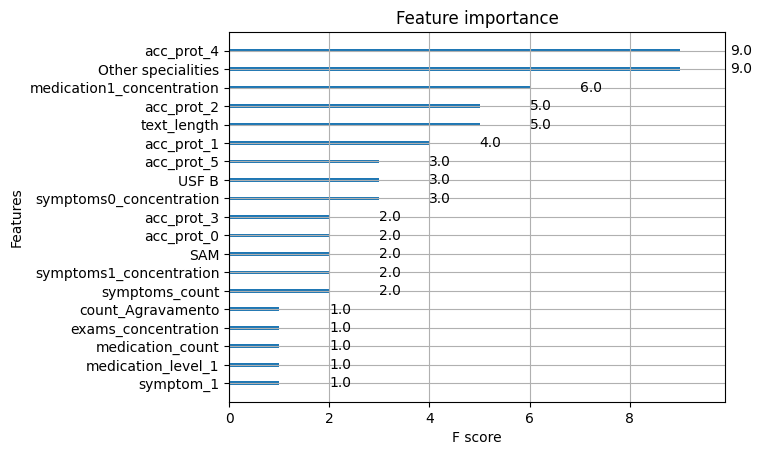

In [25]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

In [26]:
data.drop(columns_bert,axis=1,inplace=True)
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,unknown,Other specialities,2,3+,HOSP,UCSP,USF A,USF B,outro,not accepted before
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0,0,0,0,0,0,1,0,0,1
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,1,0,0,0,0,0,0,0,0,1
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0,1,0,0,0,0,0,1,0,1
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,1,0,0,0,0,0,1,0,1
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0,0,0,0,0,1,0,0,0,1
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0,0,0,0,0,0,0,1,0,1
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0,0,0,1,0,1,0,0,0,0
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0,0,0,0,0,0,0,1,0,1


In [27]:
rejection_list = protocols_refusal['Refusal'].tolist()
rejection_list

['nervosismo razão encaminhar neurologista exceto presente sinal sintoma lesão orgânico sistema nervoso central snc avaliar caso encaminhar saúde mental antes encaminhamento formal',
 'queixa somático explicação médico',
 'epilepsia controlar medicação dois ano monoterapia',
 'alteração sono insônio',
 'prevenção primário secundário doença cerebrovascular',
 'cefaleia primário típico enxaqueca tensional salvo episódica abuso medicamentoso',
 'paralisia facial periférico',
 'neurocisticercose calcificar lesão crônico inativo']

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

referrals = split_text_df['text_split'].tolist()


for index, protocol in enumerate(rejection_list):

    sentences = [protocol] + referrals

    sentences_vectors = model.encode(sentences)

    results = cosine_similarity([sentences_vectors[0]], sentences_vectors[1:])

    column_name = 'rej_prot_' + str(index)

    split_text_df[column_name] = results[0]


In [29]:
split_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7924 entries, 630 to 1227
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COD_REFERENCIA  7924 non-null   object 
 1   Texto           7924 non-null   object 
 2   text_length     7924 non-null   int64  
 3   text_split      7924 non-null   object 
 4   acc_prot_0      7924 non-null   float32
 5   acc_prot_1      7924 non-null   float32
 6   acc_prot_2      7924 non-null   float32
 7   acc_prot_3      7924 non-null   float32
 8   acc_prot_4      7924 non-null   float32
 9   acc_prot_5      7924 non-null   float32
 10  rej_prot_0      7924 non-null   float32
 11  rej_prot_1      7924 non-null   float32
 12  rej_prot_2      7924 non-null   float32
 13  rej_prot_3      7924 non-null   float32
 14  rej_prot_4      7924 non-null   float32
 15  rej_prot_5      7924 non-null   float32
 16  rej_prot_6      7924 non-null   float32
 17  rej_prot_7      7924 non-null  

In [30]:

columns_bert = ['acc_prot_0','acc_prot_1','acc_prot_2','acc_prot_3','acc_prot_4','acc_prot_5','rej_prot_0','rej_prot_1','rej_prot_2','rej_prot_3','rej_prot_4','rej_prot_5','rej_prot_6','rej_prot_7']
split_text_df2 = split_text_df.groupby('COD_REFERENCIA')[columns_bert].max()
split_text_df2

,acc_prot_0,acc_prot_1,acc_prot_2,acc_prot_3,acc_prot_4,acc_prot_5,rej_prot_0,rej_prot_1,rej_prot_2,rej_prot_3,rej_prot_4,rej_prot_5,rej_prot_6,rej_prot_7
COD_REFERENCIA,,,,,,,,,,,,,,
LOHHHSHT,0.131758,0.442293,0.268917,0.304502,0.323050,0.255526,0.184035,0.064663,0.109290,0.339974,0.199589,0.283935,0.008430,0.143222
LOHHLSTU,0.226719,0.132739,0.190538,0.267070,0.105469,0.227052,0.223764,0.335640,0.265373,0.265815,0.249983,0.219423,0.065241,0.209810
LOHHLTOL,0.426040,0.307145,0.599181,0.356770,0.443019,0.393874,0.512447,0.439913,0.441862,0.523126,0.420860,0.424226,0.362443,0.533203
LOHHLTOU,0.218256,0.320066,0.459118,0.232886,0.243360,0.315337,0.223687,0.216607,0.421527,0.323938,0.287862,0.304825,0.308378,0.289740
LOHHLTRS,0.247632,0.211375,0.245495,0.161026,0.136488,0.084279,0.341533,0.129487,0.269655,0.266796,0.084634,0.262557,0.041125,0.233403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LSHUVULH,0.182496,0.368013,0.350938,0.294268,0.247503,0.348381,0.298445,0.252078,0.283001,0.413904,0.295006,0.337169,0.270234,0.291867
LSHVHLHP,0.300475,0.320493,0.414138,0.313335,0.323930,0.385963,0.361116,0.284069,0.571867,0.432761,0.330679,0.469619,0.472891,0.306688
LSHVHLLH,0.349065,0.335451,0.464020,0.392375,0.399449,0.426315,0.352025,0.349661,0.350463,0.354333,0.260266,0.435849,0.219343,0.343957


In [31]:
data = data.merge(split_text_df2, on='COD_REFERENCIA', how='left')
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,acc_prot_4,acc_prot_5,rej_prot_0,rej_prot_1,rej_prot_2,rej_prot_3,rej_prot_4,rej_prot_5,rej_prot_6,rej_prot_7
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0.323050,0.255526,0.184035,0.064663,0.109290,0.339974,0.199589,0.283935,0.008430,0.143222
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0.105469,0.227052,0.223764,0.335640,0.265373,0.265815,0.249983,0.219423,0.065241,0.209810
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0.136488,0.084279,0.341533,0.129487,0.269655,0.266796,0.084634,0.262557,0.041125,0.233403
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0.278282,0.374722,0.264206,0.177090,0.267641,0.281688,0.232220,0.357387,0.117525,0.259695
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0.243360,0.315337,0.223687,0.216607,0.421527,0.323938,0.287862,0.304825,0.308378,0.289740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0.247503,0.348381,0.298445,0.252078,0.283001,0.413904,0.295006,0.337169,0.270234,0.291867
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0.399449,0.426315,0.352025,0.349661,0.350463,0.354333,0.260266,0.435849,0.219343,0.343957
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0.323930,0.385963,0.361116,0.284069,0.571867,0.432761,0.330679,0.469619,0.472891,0.306688
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0.333333,0.314185,0.341426,0.398472,0.327129,0.504113,0.293927,0.319940,0.173661,0.319671


In [32]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [33]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.83,0.97,0.81,0.87
1,Precision-Recall trade-off,0.53,0.83,0.96,0.82,0.88
2,Balanced Accuracy,0.66,0.82,0.83,0.90,0.91
3,Cohen's Kappa,0.62,0.83,0.88,0.88,0.92
4,Limit to K,0.64,0.82,0.84,0.89,0.91


In [34]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.68,0.95,0.68,0.68
1,Precision-Recall trade-off,0.53,0.69,0.91,0.70,0.71
2,Balanced Accuracy,0.66,0.67,0.77,0.74,0.74
3,Cohen's Kappa,0.62,0.69,0.84,0.73,0.74
4,Limit to K,0.64,0.67,0.79,0.73,0.74


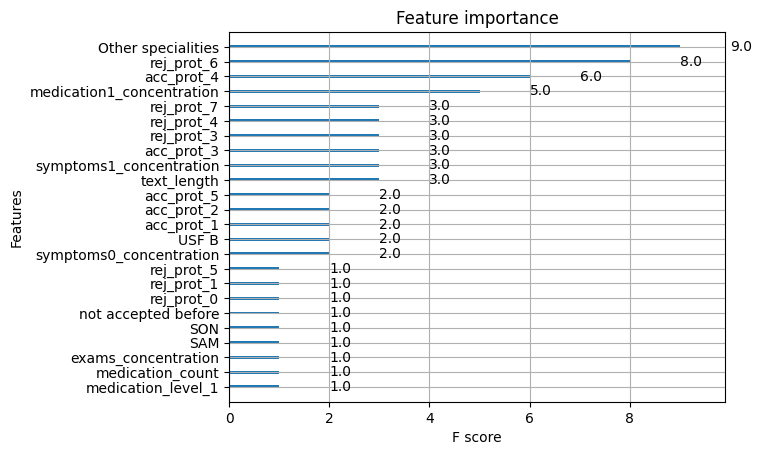

In [35]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

In [36]:
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,acc_prot_4,acc_prot_5,rej_prot_0,rej_prot_1,rej_prot_2,rej_prot_3,rej_prot_4,rej_prot_5,rej_prot_6,rej_prot_7
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0.323050,0.255526,0.184035,0.064663,0.109290,0.339974,0.199589,0.283935,0.008430,0.143222
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0.105469,0.227052,0.223764,0.335640,0.265373,0.265815,0.249983,0.219423,0.065241,0.209810
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0.136488,0.084279,0.341533,0.129487,0.269655,0.266796,0.084634,0.262557,0.041125,0.233403
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0.278282,0.374722,0.264206,0.177090,0.267641,0.281688,0.232220,0.357387,0.117525,0.259695
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0.243360,0.315337,0.223687,0.216607,0.421527,0.323938,0.287862,0.304825,0.308378,0.289740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0.247503,0.348381,0.298445,0.252078,0.283001,0.413904,0.295006,0.337169,0.270234,0.291867
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0.399449,0.426315,0.352025,0.349661,0.350463,0.354333,0.260266,0.435849,0.219343,0.343957
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0.323930,0.385963,0.361116,0.284069,0.571867,0.432761,0.330679,0.469619,0.472891,0.306688
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0.333333,0.314185,0.341426,0.398472,0.327129,0.504113,0.293927,0.319940,0.173661,0.319671


In [37]:
# columns_bert = ['accep_prot_0', 'accep_prot_1', 'accep_prot_2', 'accep_prot_3', 'accep_prot_4', 'accep_prot_5', 'rej_prot_0', 'rej_prot_1', 'rej_prot_2', 'rej_prot_3', 'rej_prot_4', 'rej_prot_5', 'rej_prot_6', 'rej_prot_7']
columns_bert = ['acc_prot_0','acc_prot_1','acc_prot_2','acc_prot_3','acc_prot_4','acc_prot_5','rej_prot_0','rej_prot_1','rej_prot_2','rej_prot_3','rej_prot_4','rej_prot_5','rej_prot_6','rej_prot_7']

data[columns_bert].describe()

,acc_prot_0,acc_prot_1,acc_prot_2,acc_prot_3,acc_prot_4,acc_prot_5,rej_prot_0,rej_prot_1,rej_prot_2,rej_prot_3,rej_prot_4,rej_prot_5,rej_prot_6,rej_prot_7
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000
mean,0.266329,0.261455,0.318177,0.292343,0.285040,0.291987,0.296101,0.300190,0.314556,0.329140,0.270222,0.329063,0.178109,0.262137
std,0.113799,0.110845,0.111533,0.080197,0.128444,0.109474,0.110715,0.115956,0.097810,0.123499,0.094189,0.102288,0.088354,0.095542
min,-0.117852,-0.060738,-0.107683,-0.064365,-0.061193,-0.085086,-0.084285,-0.097012,-0.109843,-0.062793,-0.081803,-0.032041,-0.105195,-0.090195
25%,0.203051,0.180787,0.241151,0.261878,0.199332,0.227052,0.223764,0.239321,0.265373,0.265815,0.215312,0.261738,0.113619,0.209810
50%,0.252375,0.262288,0.335161,0.298821,0.290997,0.299946,0.300136,0.310636,0.316500,0.316709,0.270706,0.332484,0.183687,0.263143
75%,0.330396,0.329438,0.398377,0.345624,0.367801,0.356779,0.375349,0.361197,0.376295,0.395087,0.333787,0.394784,0.239333,0.324261
max,0.791099,0.629479,0.599181,0.594996,0.814135,0.756514,0.603528,0.698010,0.594867,0.756560,0.746333,0.655304,0.553595,0.579293


In [38]:
data2 = data.copy()


# Calculate quartiles for each score column
score_cols = columns_bert  # replace with your actual column names
quartile_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile', '90_quantile']
for col in score_cols:
    quartile_bins = [0, data2[col].quantile(0.25), data2[col].quantile(0.5), data2[col].quantile(0.75), data2[col].quantile(0.90), float('inf')]
    data2[col + '_quartile'] = pd.cut(data2[col], bins=quartile_bins, labels=quartile_labels)
    # data2[col + '_flag'] = (data2[col + '_quartile'] == quartile_labels[0]).astype(int)


In [41]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 96 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-null 

In [42]:
results = pd.DataFrame({'quartile': quartile_labels})

columns_quartile = ['acc_prot_0_quartile','acc_prot_1_quartile','acc_prot_2_quartile','acc_prot_3_quartile','acc_prot_4_quartile','acc_prot_5_quartile','rej_prot_0_quartile','rej_prot_1_quartile','rej_prot_2_quartile','rej_prot_3_quartile','rej_prot_4_quartile','rej_prot_5_quartile','rej_prot_6_quartile','rej_prot_7_quartile']

for i , col in enumerate(columns_quartile):
    teste = data2.groupby(col)['result'].sum().reset_index()
    teste.rename(columns={'result': 'sum_'+str(i)}, inplace=True)
    teste2 = data2.groupby(col)['result'].count().reset_index()
    teste2.rename(columns={'result': 'count_'+str(i)}, inplace=True)
    results = results.merge(teste, left_on='quartile', right_on= col, how='left')
    results = results.drop(col,axis=1)
    results = results.merge(teste2, left_on='quartile', right_on= col, how='left')
    results = results.drop(col,axis=1)
    results[columns_bert[i]] = results['sum_'+str(i)]/results['count_'+str(i)]
    results = results.drop(['sum_'+str(i),'count_'+str(i)],axis=1)
  


results

,quartile,acc_prot_0,acc_prot_1,acc_prot_2,acc_prot_3,acc_prot_4,acc_prot_5,rej_prot_0,rej_prot_1,rej_prot_2,rej_prot_3,rej_prot_4,rej_prot_5,rej_prot_6,rej_prot_7
0,1st Quartile,0.703412,0.500000,0.484848,0.683292,0.492386,0.491266,0.482301,0.690537,0.498016,0.517578,0.690355,0.465995,0.462766,0.546039
1,2nd Quartile,0.490050,0.689826,0.699005,0.504975,0.681592,0.651026,0.722388,0.721393,0.709459,0.730104,0.480100,0.713930,0.679104,0.659574
2,3rd Quartile,0.768657,0.735661,0.728856,0.731343,0.741294,0.786070,0.738806,0.537313,0.748756,0.771144,0.741294,0.771144,0.738806,0.771144
3,4th Quartile,0.771784,0.763485,0.800830,0.796680,0.804979,0.809129,0.813278,0.788382,0.817427,0.767635,0.809129,0.780083,0.853755,0.800830
4,90_quantile,0.751553,0.863354,0.832298,0.832298,0.813665,0.844720,0.795031,0.770186,0.844720,0.782609,0.844720,0.770186,0.812081,0.726708
